In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['axes.titlesize'] = 12

%matplotlib inline

### Exercise 9.

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [3]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [221]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV

In [5]:
def time_a_model(model, trainset, testset=None, predict=False):
    X_train, y_train = trainset
    t1 = time.time()
    model.fit(X_train, y_train)
    t2 = time.time()
    print(f'Fitting {model.__class__.__name__} with sample shape {X_train.shape} took {t2-t1:.1f} seconds.')
    if predict:
        X_test, y_test = testset
        y_predicted = model.predict(X_test)
        print(f'Accuracy on test set: {accuracy_score(y_test, y_predicted):.3f}')
        return y_predicted

Train a random forest directly

In [6]:
rnd_clf = RandomForestClassifier(n_estimators=200, min_samples_split=5, random_state=42, n_jobs=2)

y_predicted = time_a_model(rnd_clf, (X_train, y_train), (X_test, y_test), True)

Fitting RandomForestClassifier with sample shape (60000, 784) took 37.7 seconds.
Accuracy on test set: 0.970


Train PCA and then random forest

In [7]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.95)),
    ('rnd', rnd_clf)
])

y_predicted_pca = time_a_model(pipeline, (X_train, y_train), (X_test, y_test), True)

Fitting Pipeline with sample shape (60000, 784) took 98.1 seconds.
Accuracy on test set: 0.951


Train a logistic regression with softmax

In [29]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)

_ = time_a_model(log_reg, (X_train, y_train), (X_test, y_test), True)

Fitting LogisticRegression with sample shape (60000, 784) took 18.6 seconds.
Accuracy on test set: 0.925


/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train PCA and then a logistic regression with softmax

In [32]:
t1 = time.time()
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
t2 = time.time()
print(f"{t2-t1:.1f} seconds for using PCA in transforming trainset")
_ = time_a_model(log_reg, (X_reduced, y_train), (X_test_reduced, y_test), True)

5.5 seconds for using PCA in transforming trainset
Fitting LogisticRegression with sample shape (60000, 154) took 5.6 seconds.
Accuracy on test set: 0.920


/Applications/anaconda3/envs/stats/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Exercise 10. t-SNE and umap

#### t-SNE

In [167]:
sample_indices = np.random.choice(X_train.shape[0], size=6000, replace=False)
train_idx = sample_indices[:5000]
test_idx = sample_indices[5000:]

In [168]:
tsne =  TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_train[train_idx])

In [198]:
def plot_digits(X, y, title=None):
    # get center of each digit
    pd_center = pd.DataFrame({'y': y, 'x1': X[:, 0], 'x2': X[:, 1]}).groupby('y').median().reset_index()
    
    fig=plt.figure(figsize=(10,7))
    plt.scatter(X[:,0], X[:,1], c=y, cmap='Spectral', alpha=0.7, s=3, marker='o')
    for digit, x1, x2 in pd_center.to_numpy():
        plt.text(x1, x2, s=int(digit), fontdict={"weight": "bold", "size": 15})
    plt.colorbar(ticks=np.arange(10), boundaries=np.arange(11)-0.5)
    plt.axis("off")
    if title:
        plt.title(title, fontsize=18)

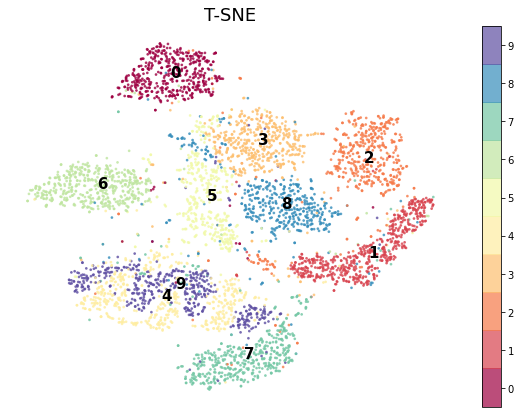

In [199]:
plot_digits(X_reduced_tsne, y_train[train_idx], 'T-SNE')

#### UMAP
1. fit umap to trainset and plot trainset embeddings, static and interactive for fun
2. use embedding from step 1. to transform new data and plot testset embeddings
3. repeat step 1 and 2 with supervised umap
4. combine supervised umap with randomforest classifier, gridsearch both umap and rnd_clf hyperparameters

In [207]:
import umap
import umap.plot

#### Steps 1 & 2. fit on train then transform on test. Unsupervised

In [201]:
unsup_umap = umap.UMAP(n_components=2, random_state=42)
X_reduced_unsup_umap = unsup_umap.fit_transform(X_train[train_idx])

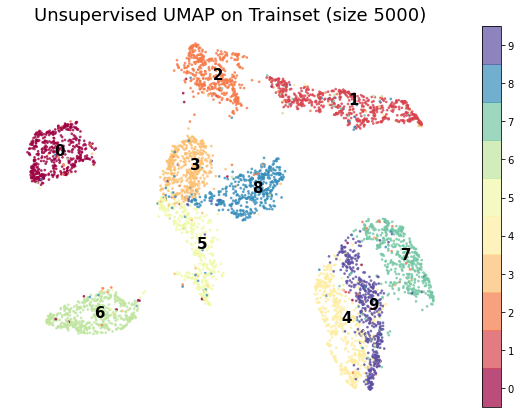

In [204]:
plot_digits(X_reduced_unsup_umap, y_train[train_idx], title=f'Unsupervised UMAP on Trainset (size {len(train_idx)})')

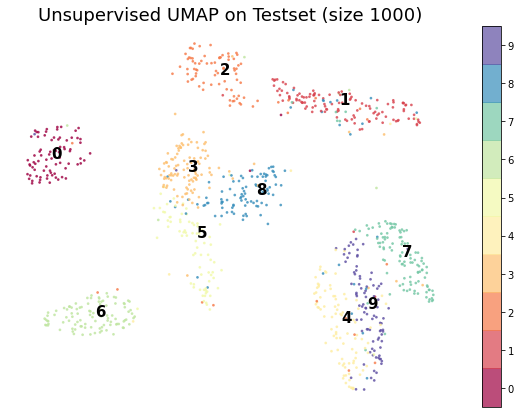

In [205]:
X_unsup_umap_test = unsup_umap.transform(X_train[test_idx])
plot_digits(X_unsup_umap_test, y_train[test_idx], f'Unsupervised UMAP on Testset (size {len(test_idx)})')

Interactive plots

In [209]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [214]:
hover_data = pd.DataFrame({'index': train_idx, 'digit': y_train[train_idx]})
p = umap.plot.interactive(unsup_umap, labels=y_train[train_idx], hover_data=hover_data, point_size=2, cmap='Spectral', width=400, height=400)
umap.plot.show(p)

#### Steps 3. fit on train then transform on test. Supervised

In [218]:
sup_umap = umap.UMAP(n_components=2, random_state=42)
X_train_sup_umap = sup_umap.fit_transform(X_train[train_idx], y=y_train[train_idx])

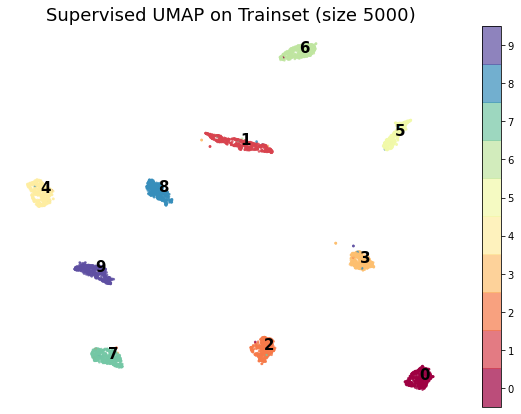

In [219]:
plot_digits(X_train_sup_umap, y_train[train_idx], title=f'Supervised UMAP on Trainset (size {len(train_idx)})')

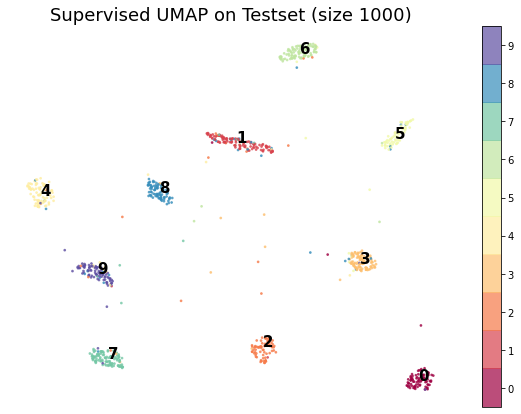

In [220]:
X_test_sup_umap = sup_umap.transform(X_train[test_idx])
plot_digits(X_test_sup_umap, y_train[test_idx], f'Supervised UMAP on Testset (size {len(test_idx)})')

#### UMAP with randomforest

In [227]:
pipeline = Pipeline([
    ('umap', umap.UMAP(random_state=42)),
    ('rf_clf', RandomForestClassifier(min_samples_split=5, random_state=42))
])

param_grid = [{
    "umap__n_components": [2, 20],
    "rf_clf__n_estimators": [100, 200] 
}]

gridcv = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=3, verbose=2)
gridcv.fit(X_train[train_idx], y_train[train_idx])

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed:  1.8min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('umap', UMAP(random_state=42)),
                                       ('rf_clf',
                                        RandomForestClassifier(min_samples_split=5,
                                                               random_state=42))]),
             n_jobs=4,
             param_grid=[{'rf_clf__n_estimators': [100, 200],
                          'umap__n_components': [2, 20]}],
             verbose=2)

In [233]:
pd.DataFrame(gridcv.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf_clf__n_estimators,param_umap__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,24.1880,2.7597,11.6296,1.7228,100,20,"{'rf_clf__n_estimators': 100, 'umap__n_components': 20}",0.9082,0.9022,0.9028,0.9044,0.0027,1
3,23.6984,0.1398,9.9332,0.0630,200,20,"{'rf_clf__n_estimators': 200, 'umap__n_components': 20}",0.9076,0.9016,0.9022,0.9038,0.0027,2
0,23.7021,0.1435,13.3752,0.0998,100,2,"{'rf_clf__n_estimators': 100, 'umap__n_components': 2}",0.9070,0.9028,0.8938,0.9012,0.0055,3
2,18.5879,0.4088,9.9860,0.2034,200,2,"{'rf_clf__n_estimators': 200, 'umap__n_components': 2}",0.9058,0.9028,0.8944,0.9010,0.0049,4


In [235]:
accuracy_score(y_train[test_idx], gridcv.best_estimator_.predict(X_train[test_idx]))

0.899

In [237]:
time_a_model(gridcv.best_estimator_, (X_train, y_train), testset=(X_test, y_test), predict=True)

Fitting Pipeline with sample shape (60000, 784) took 142.4 seconds.
Accuracy on test set: 0.963


array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)